# Who's the biggest tax evader?

#### Imports:

In [92]:
import plotly.plotly as py
import pandas as pd
import pycountry
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

## 1. Data cleaning and preprocessing

### 1.1 Loading data

The goal is to better understand how different socio-economic factors are linked with tax evasion occurrences in different countries. To help us visualize this, we will use choropleth world maps to display information.

We have observed in our datasets that certain countries are referred to under different names, for instance "China" vs "People's Republic of China". Also, since we are considering data that spans over multiple years, we run into issues with countries that have changed their names, for instance Swaziland becoming Eswatini. Thus, we decided to use [ISO 3166-1](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) three-letter country codes as the identifiers for countries, as these values are consistent for all countries and through the years. From the Plotly choropleth map [documentation](https://plot.ly/python/choropleth-maps/#world-choropleth-map), we got a list of ISO country codes and country names. We choose to complete this dataset ourselves manually, when we come across new ways of writing country names. We load the dataset of country codes as a Pandas `DataFrame`:

In [2]:
# Load country codes
df_country_codes = pd.read_csv('data/countries_codes.csv', low_memory=False).set_index('COUNTRY')

We load the Panamas Papers, UN and World Bank datasets into Pandas `DataFrame`s:

In [3]:
# Load datasets
## Load panama papers datasets
pp_edges = pd.read_csv('data/panama_papers/panama_papers.edges.csv', low_memory=False)
pp_nodes_address = pd.read_csv('data/panama_papers/panama_papers.nodes.address.csv', low_memory=False)
pp_nodes_entity = pd.read_csv('data/panama_papers/panama_papers.nodes.entity.csv', low_memory=False)
pp_nodes_intermediary = pd.read_csv('data/panama_papers/panama_papers.nodes.intermediary.csv', low_memory=False)
pp_nodes_officer = pd.read_csv('data/panama_papers/panama_papers.nodes.officer.csv', low_memory=False)
## Load UN datasets
un_hdi_components_2014 = pd.read_csv('data/un/hdi_components.csv', low_memory=False)
un_gdp_per_capita = pd.read_csv('data/un/gdp_per_capita.csv', low_memory=False)
un_gdp_per_capita_ppp = pd.read_csv('data/un/gdp_per_capita_PPP.csv', low_memory=False)
## Load world bank datasets
wb_gini = pd.read_csv('data/world_bank/gini_index.csv', low_memory=False)
wb_income_share_20_per = pd.read_csv('data/world_bank/income_share_20_per.csv', low_memory=False)
wb_population_total = pd.read_csv('data/world_bank/population_total.csv', low_memory=False)
wb_population_2014 = wb_population_total[['Country Code', '2014']]

### 1.2 Examining data

We look at a few of the datasets, to see what sort of preprocessing and cleaning we will have to do.

#### UN: GDP per capita

In [4]:
un_gdp_per_capita.head()

,Country,Year,Item,Value
0,Afghanistan,2016,Gross Domestic Product (GDP),583.882867
1,Afghanistan,2015,Gross Domestic Product (GDP),610.854517
2,Afghanistan,2014,Gross Domestic Product (GDP),651.158326
3,Afghanistan,2013,Gross Domestic Product (GDP),681.033974
4,Afghanistan,2012,Gross Domestic Product (GDP),694.885886


#### UN: HDI components (2014)

In [5]:
un_hdi_components_2014.head()

,HDI rank,Country,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank
0,1,Norway,0.944,81.6,17.5,12.6,64992,5
1,2,Australia,0.935,82.4,20.2,13,42261,17
2,3,Switzerland,0.93,83,15.8,12.8,56431,6
3,4,Denmark,0.923,80.2,18.7,12.7,44025,11
4,5,Netherlands,0.922,81.6,17.9,11.9,45435,9


#### World Bank: Gini coefficient index

In [6]:
wb_gini.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### World Bank: Income share top 20%

In [7]:
wb_income_share_20_per.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,48.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,39.0,NaN,NaN,NaN,37.8,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Panama Papers: addresses

In [8]:
pp_nodes_address.head()

,node_id,name,address,country_codes,countries,sourceID,valid_until,note
0,14000001,NaN,-\t27 ROSEWOOD DRIVE #16-19 SINGAPORE 737920,SGP,Singapore,Panama Papers,The Panama Papers data is current through 2015,NaN
1,14000002,NaN,"""Almaly Village"" v.5, Almaty Kazakhstan",KAZ,Kazakhstan,Panama Papers,The Panama Papers data is current through 2015,NaN
2,14000003,NaN,"""Cantonia"" South Road St Georges Hill Weybridg...",GBR,United Kingdom,Panama Papers,The Panama Papers data is current through 2015,NaN
3,14000004,NaN,"""CAY-OS"" NEW ROAD; ST.SAMPSON; GUERNSEY; CHANN...",GGY,Guernsey,Panama Papers,The Panama Papers data is current through 2015,NaN
4,14000005,NaN,"""Chirag"" Plot No 652; Mwamba Road; Kizingo; Mo...",KEN,Kenya,Panama Papers,The Panama Papers data is current through 2015,NaN


We see that neither of the two displayed UN datasets have a `Country Code` column. Fortunately, we are able to map `Country Name` values to their corresponding `Country Code` values. This will allow us to join `DataFrame`s later on, when performing analyses on socio-economic development factors.

We also observe that there are many NaN values in the Gini coefficient index dataset and the income share top 20% dataset. This is because these values are not measured annually in every country. We will solve this problem by taking the most recent value since 2000, for each of these datasets. This allows us to have the most accurate recent data possible.

#### Country location
To make it easier to draw our data, we also load a data of countries capital location (Longitude and Latitude).

In [9]:
countries_location = pd.read_csv('data/countries_latitude_longitude.csv')
countries_location = countries_location[['Alpha-3 code', 'Latitude (average)', 'Longitude (average)']]
countries_location = countries_location.rename(columns={'Alpha-3 code': 'Code', 'Latitude (average)': 'lat', 
                                                        'Longitude (average)': 'long'})

### 1.3 Data cleaning

***Select most recent statistics:***

For the Gini coefficient index and income share top 20% datasets, we are going to take the most recent value since 2000.

In [10]:
# We only consider statistics that date from 2000 onwards
years_to_drop = list(map(str, np.arange(1960, 2000)))
wb_gini = wb_gini.drop(columns=years_to_drop)
wb_income_share_20_per = wb_income_share_20_per.drop(columns=years_to_drop)

In [11]:
# We select the rightmost value (most recent) for each row
gini_values = wb_gini.stack().groupby(level=0).last().reindex(wb_gini.index)

# Only select valid values and label other values as NaN
wb_gini['Gini'] = pd.to_numeric(gini_values, errors='coerce')

# Only select relevant columns
wb_gini = wb_gini[['Country Name', 'Country Code', 'Gini']]

In [12]:
# We select the rightmost value (most recent) for each row
income_share_20_per_values = wb_income_share_20_per.stack().groupby(level=0).last().reindex(wb_income_share_20_per.index)

# Only select valid values and label other values as NaN
wb_income_share_20_per['Income Share'] = pd.to_numeric(income_share_20_per_values, errors='coerce')

# Only select relevant columns
wb_income_share_20_per = wb_income_share_20_per[['Country Name', 'Country Code', 'Income Share']]

***Add country codes to UN datasets:***

In order to display the values on maps, we need the UN datasets to contain country codes. We will perform a join on each of the UN datasets with the country codes dataset, `df_country_codes`. We will attempt to automate this process, before considering any exceptions:

In [13]:
# Join UN datasets with country codes DataFrame
un_hdi_components_2014 = un_hdi_components_2014.join(df_country_codes, on='Country')
un_gdp_per_capita = un_gdp_per_capita.join(df_country_codes, on='Country')
un_gdp_per_capita_ppp = un_gdp_per_capita_ppp.join(df_country_codes, on='Country')

We remove any parts of a country name that contain parentheses, for instance "Iran (Islamic Republic of)" becomes "Iran":

In [14]:
# List of UN DataFrames
un_dfs = [un_hdi_components_2014, un_gdp_per_capita, un_gdp_per_capita_ppp]

# Define dictionary containing pairs (country name: ISO country code)
countries = dict()

for country in pycountry.countries:
    countries[country.name] = country.alpha_3  

for df in un_dfs:
    nan_values = df['CODE'].isna()
    input_countries = list(df[nan_values]['Country'].values)
        
    codes = []
    for country in input_countries:
        if country in countries:
            codes.append(countries.get(country))
        else:        
            accepted = []
            str_country = str(country)
            # check if string contains either common or official country name
            for p_country in pycountry.countries:
                if p_country.name in str_country or (hasattr(p_country, 'common_name') and p_country.common_name in str_country):
                    accepted.append(p_country.alpha_3)
            if len(accepted) == 1:
                codes.append(accepted[0])
            else:
                codes.append(None)

    df.loc[nan_values, 'CODE'] = codes
    # Remove rows that were not found
    df = df[df['CODE'].notnull()]

### 1.4 Data processing

We start by counting the number of intermediaries, officers and entities per country. This will give us a brief overview of which countries were involved and how they were involved. It will also help us find where to look to find additional interesting information.

***Number of Panama Papers references for intermediaries per country:***

In [16]:
pp_intermediary_country = pp_nodes_intermediary.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_intermediary_country = pp_intermediary_country.sort_values('counts', ascending=False)
pp_intermediary_country.head(5)

,country_codes,countries,counts
91,HKG,Hong Kong,2202
75,GBR,United Kingdom,1367
28,CHE,Switzerland,1218
217,USA,United States,603
161,PAN,Panama,552


***Number of Panama Papers references for officers per country:***

In [17]:
pp_officer_country = pp_nodes_officer.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_officer_country = pp_officer_country.sort_values('counts', ascending=False)
pp_officer_country.head(5)

,country_codes,countries,counts
33,CHN,China,24635
75,HKG,Hong Kong,13362
192,VGB,British Virgin Islands,11231
90,JEY,Jersey,6892
142,PAN,Panama,5069


***Number of Panama Papers references for entities per country:***

In [18]:
pp_entity_country = pp_nodes_entity.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_entity_country = pp_entity_country.sort_values('counts', ascending=False)
pp_entity_country.head(5)

,country_codes,countries,counts
59,HKG,Hong Kong,37911
27,CHE,Switzerland,37911
114,PAN,Panama,15811
73,JEY,Jersey,14331
89,LUX,Luxembourg,10840


***Total Number of Panama Papers references per country:***

Since one of our major interests is to study the distribution of Panama Papers references per country, we create a dataset containing country codes and the number of occurrences of that country across the datasets, merging `pp_intermediary_country`, `pp_officer_country`, `pp_entity_country`

In [80]:
# Merge all 3 tables
pp_total_country = pp_intermediary_country.merge(pp_entity_country, left_on='country_codes', right_on='country_codes').merge(pp_officer_country, left_on='country_codes', right_on='country_codes')
# Merge it with country location to make it easier to plot
pp_total_country = pp_total_country.merge(countries_location,left_on='country_codes',right_on='Code')
# Sum the diferent counts
pp_total_country['total'] = pp_total_country['counts_x'] + pp_total_country['counts_y'] + pp_total_country['counts']
pp_total_country = pp_total_country[['country_codes', 'countries', 'total', 'lat','long']]
# Display top 5 table
pp_total_country[['country_codes','countries','total']].sort_values('total', ascending=False).head(5)

,country_codes,countries,total
0,HKG,Hong Kong,53475
2,CHE,Switzerland,43397
10,CHN,China,28101
4,PAN,Panama,21432
1,GBR,United Kingdom,15900


***Number of Panama Papers references with respect to population size:***

Knowing the number of appearances of each country in the addresses leaked in Panama Papers is not very useful; some countries have a much bigger population and will therefore be over-represented. We normalize the number of occurrences by population size using the following formula:
$$ count_{1000} = \frac{nb \, occurrences}{population_{2014}} $$

We also normalize it by the percentage of income share held by the top 20% using the following formula:
$$ count_{inc_{20}} = {nb \, occurrences} \cdot {percentage_{inc_{20}}} $$

In [69]:
def normalize(df, value_col):
    df_normalized = df.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')
    df_normalized = df_normalized.merge(wb_income_share_20_per, left_on='country_codes', right_on='Country Code')
    df_normalized['counts_normalized_population'] = 1000 * df_normalized[value_col] / df_normalized['2014']
    df_normalized['counts_normalized_income_share'] = df_normalized[value_col] * df_normalized['Income Share'] / 100
    return df_normalized

In [70]:
pp_intermediary_country_normalized = normalize(pp_intermediary_country, 'counts')
pp_officer_country_normalized = normalize(pp_officer_country, 'counts')
pp_entity_country_normalized = normalize(pp_entity_country, 'counts')
pp_total_country_normalized = normalize(pp_total_country, 'total')

***Number of Panama Papers references for intermediaries per country normalized by population:***

In [71]:
pp_intermediary_country_normalized[['countries', 'counts_normalized_population']].sort_values('counts_normalized_population', ascending=False).head(5)

,countries,counts_normalized_population
16,Monaco,4.274625
19,Liechtenstein,3.151345
12,Isle of Man,2.494249
27,Gibraltar,2.085904
46,British Virgin Islands,1.013925


***Number of Panama Papers references for intermediaries per country normalized by income share:***

In [72]:
pp_intermediary_country_normalized[['countries', 'counts_normalized_income_share']].sort_values('counts_normalized_income_share', ascending=False).head(5)

,countries,counts_normalized_income_share
1,United Kingdom,555.002
2,Switzerland,489.636
4,Panama,302.496
3,United States,282.807
5,Guatemala,236.376


***Number of Panama Papers references for officers per country normalized by population:***

In [73]:
pp_officer_country_normalized[['countries', 'counts_normalized_population']].sort_values('counts_normalized_population', ascending=False).head(5)

,countries,counts_normalized_population
2,British Virgin Islands,379.579559
20,Monaco,35.114864
26,Liechtenstein,29.170146
30,Gibraltar,26.176626
13,Isle of Man,24.082819


***Number of Panama Papers references for officers per country normalized by income share:***

In [74]:
pp_officer_country_normalized[['countries', 'counts_normalized_income_share']].sort_values('counts_normalized_income_share', ascending=False).head(5)

,countries,counts_normalized_income_share
0,China,11800.165
3,Panama,2777.812
4,United Kingdom,1995.084
6,Russia,1865.907
5,Switzerland,1715.736


***Number of Panama Papers references for entities per country normalized by population:***

In [75]:
pp_entity_country_normalized[['countries', 'counts_normalized_population']].sort_values('counts_normalized_population', ascending=False).head(5)

,countries,counts_normalized_population
13,Monaco,83.079828
16,Gibraltar,59.903637
8,Isle of Man,59.232353
15,Liechtenstein,55.646834
27,British Virgin Islands,37.413816


***Number of Panama Papers references for entities per country normalized by income share:***

In [76]:
pp_entity_country_normalized[['countries', 'counts_normalized_income_share']].sort_values('counts_normalized_income_share', ascending=False).head(5)

,countries,counts_normalized_income_share
1,Switzerland,15240.222
2,Panama,8664.428
3,Luxembourg,4444.400
4,United Kingdom,3905.314
7,Uruguay,2251.854


***Total Number of Panama Papers references per country normalized by population:***

In [77]:
pp_total_country_normalized[['countries', 'counts_normalized_population']].sort_values('counts_normalized_population', ascending=False).head(5)

,countries,counts_normalized_population
6,British Virgin Islands,418.007300
15,Monaco,122.469317
20,Gibraltar,88.166167
18,Liechtenstein,87.968325
11,Isle of Man,85.809420


***Total Number of Panama Papers references per country normalized by income share:***

In [78]:
pp_total_country_normalized[['countries', 'counts_normalized_income_share']].sort_values('counts_normalized_income_share', ascending=False).head(5)

,countries,counts_normalized_income_share
1,Switzerland,17445.594
2,China,13460.379
3,Panama,11744.736
4,United Kingdom,6455.400
5,Luxembourg,5323.030


## 2. Data analysis and observations

### 2.1 Panama Papers and population

First, we study the distribution of the number of Panama Papers references in each country per 1000 inhabitants, to get a better idea of what kind of data we are dealing with.

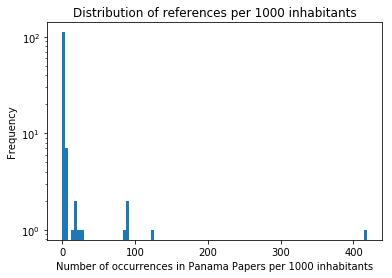

In [85]:
pp_total_country_normalized['counts_normalized_population'].plot.hist(title='Distribution of references per 1000 inhabitants', bins=100, logy=True)
plt.xlabel('Number of occurrences in Panama Papers per 1000 inhabitants')
plt.show()

If we again look at the table with the highest occurrence to population ratio, we can see which countries were involved:

In [89]:
pp_total_country_normalized[['countries', 'counts_normalized_population']].sort_values('counts_normalized_population', ascending=False).head(5)

,countries,counts_normalized_population
6,British Virgin Islands,418.007300
15,Monaco,122.469317
20,Gibraltar,88.166167
18,Liechtenstein,87.968325
11,Isle of Man,85.809420


We observe that a large majority of countries are almost not cited in Panama Papers (relative to the population size). The rest of the countries have fewer than 40 references per 1000 in habitants, and there is one extreme outlier with 418 references per 1000 inhabitants. This odd distribution is probably due to the fact there were a few countries that were extremely involved, while the vast majority was simply a small percentage of the extremely rich population that was participating in this scandal.

But let us now try to provide a better visualization of this results, to see if we can understand how they are distributed.

### 2.2 Panama Papers intermediaries

So far we looked at how the number of occurrences is distributed, but not so much at which countries were involved. Thus we decided to look at 2 additional ways of displaying this data, allowing us a better understanding of who was involved:
- Bar plot
- Choropleth plot

For the Choropleth plot however, we realized that very small countries (for instance, tiny islands commonly known as tax havens) were not visible, even though they were heavily implicated. Thus we decided to instead of using the color to display the number of occurrences, to use markers on the location of those islands, with size proportional to the number of occurrences.

We will start by looking at the total number of occurrences, and then look at the number occurrences to population ratio:

In [95]:
def plot_map(df, col_value, limits, title, filename=None, save=False, size=10, sizemin=1):
    """ 
    Utility function to add world map plot using markers, divided into separate groups
    """
    df = df[df[col_value].notnull()].sort_values(col_value, ascending=False)
    
    data = []
    max_v = df[col_value].max()
    
    for i in range(len(limits)):
        lim = limits[i]
        df_sub = df[lim[0]:lim[1]]
        data.append(go.Scattergeo(
                lon = df_sub['long'],
                lat = df_sub['lat'],
                text = df_sub['countries'].astype(str) + " : " + df_sub[col_value].astype(str),
                showlegend = True,
                geo = 'geo2',
                marker = dict(
                    size = df_sub[col_value],
                    sizeref=2. * max_v / (size ** 2),
                    line = dict(width = 0),
                    sizemin=sizemin,
                ),
                name='{0:.2f} - {1:.2f}'.format( df_sub.iloc[-1][col_value], df_sub.iloc[0][col_value]),
        ))


    layout = dict(
        title = title,
        autorange=True,
        scrollzoom=True,
        geo2 = dict(
            showcountries = True,
            countrycolor = "rgb(217, 217, 217)",
            showframe = True,
            resolution=1,
            legend=True,
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5,
            showcoastlines = True,
            projection = dict(
                type = 'Mercator'
            ),
            bgcolor = 'rgba(255, 255, 255, 0.0)',
        )
    )

    fig = dict( data=data, layout=layout)

    iplot( fig, validate=False)
    if save:
        plot( fig, validate=False, filename='../TrovatelliT.github.io/ressources/' + filename, auto_open=False)

In [96]:
sorted_data = pp_total_country[['countries','total']].sort_values('total', ascending=False).head(15)

data = [go.Bar(
            x=sorted_data['countries'],
            y=sorted_data['total'],
    )]


layout = go.Layout(
    title='Number of occurrences',
)

fig = go.Figure(data=data, layout=layout)
plot(fig, filename='../TrovatelliT.github.io/ressources/bar_occurrences', auto_open=False)
iplot(fig, filename='bar_occurences')


In [97]:
limits = [(0,2),(3,10),(11,20),(21,50),(50,len(pp_total_country))]
plot_map(pp_total_country, 'total', limits, 'Number of occurrences','map_occurrences',size=10, sizemin=1.5)

There are a few countries that clearly standout, but let us just look at the top 5: Hong Kong, Switzerland, China, Panama and United Kingdom.

The first two are more or less expected. According to many reports, Hong Kong is often used by Chinese Businessmen to hide their money, and given the size of the Chinese population and their position the ranking, this is somewhat expected. Along the same line, Switzerland is known for its banks and banking secrecy, and was historically used by the rich and famous to avoid paying taxes. So again, this result was predictable.

China appears as well, and this is more or less expected due to their population size and levels of corruption.

The last two are the most interesting. Panama is generally perceived as a tax haven, but still not anywhere the level other more known tax havens such as Cayman Islands or Luxembourg. But their presence in this top 5 is easily explained by the fact Mossack Fonseca, the company responsible for creating the majority of the shell companies used in this scandal, was a Panamese company. But it also had large links with the UK and other Commonwealth regions, which explains the UK high position as well.

Other then this specific examples, we seem to see a combination of very populated countries and tax havens. But of course, it's expected that more populated countries will have a larger number of occurrences. So we will now look at the occurrences to population ratio:

In [98]:
sorted_data = pp_total_country_normalized[['countries','counts_normalized_population']].sort_values('counts_normalized_population', ascending=False).head(15)

data = [go.Bar(
            x=sorted_data['countries'],
            y=sorted_data['counts_normalized_population'],
    )]


layout = go.Layout(
    title='Number of occurrences per capita',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='../TrovatelliT.github.io/ressources/bar_occurrences_per_hab')
plot(fig, filename='../TrovatelliT.github.io/ressources/bar_occurrences_per_hab', auto_open=False)


/home/pedro/.local/lib/python3.6/site-packages/plotly/offline/offline.py:608: UserWarning:

Your filename `../TrovatelliT.github.io/ressources/bar_occurrences_per_hab` didn't end with .html. Adding .html to the end of your file.



'file:///home/pedro/workspace/ada-project/TrovatelliT.github.io/ressources/bar_occurrences_per_hab.html'

In [99]:
plot_map(pp_total_country_normalized, 'counts_normalized_population', limits, 'Number of occurrences per capita', 'map_occurrences_per_hab', size=10, sizemin=1.5)

This plots show a much different picture. We see that almost all of the countries mentioned are countries which are typically known as "tax-havens", such as Seychelles, Cayman and Bermuda. We see however that all of them are dwarfed by the British Virgin Islands. This again matches the [reports](http://www.independent.com.mt/articles/2016-04-18/world-news/Panama-Papers-Tiny-British-Virgin-Islands-has-big-role-in-leaked-documents-6736156470) about this affair, which indicate the British Virgin Islands was were a large number of the shell companies were created.